$$
\newcommand{\N}{\mathbb{N}}  % Natural numbers
\newcommand{\Z}{\mathbb{Z}}  % Integers
\newcommand{\R}{\mathbb{R}}  % Real numbers
\newcommand{\C}{\mathbb{C}}  % Complex numbers
\newcommand{\Q}{\mathbb{Q}}  % Rational numbers
\newcommand{\p}{\partial}  %  for partial derivatives
\newcommand{\f}{\frac} % fractions
\newcommand{\mb}{\mathbf}
\newcommand{\tr}{\mathrm{tr}}
%\newcommand{\det}{\mathrm{det}}
\newcommand{\ra}{\Rightarrow}
\newcommand{\upa}{\uparrow}
\newcommand{\lra}{\Leftrightarrow}
\newcommand{\lan}{\langle}
\newcommand{\ran}{\rangle}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\inn}[1]{\lan#1\ran}
\newcommand{\floor}[1]{\lfloor#1\rfloor}
\newcommand{\ol}{\overline}
\newcommand{\cross}{\times}
\newcommand{\F}{\mathbf{F}}
\newcommand{\M}{\mathcal{M}}
\newcommand{\bhat}{\widehat}
%\newcommand{\L}{\mathcal{L}}
%\newcommand{\span}{\textrm{span}}
%\newcommand{\null}{\textrm{null}}
\newcommand{\res}{\textrm{Res}}
\newcommand{\ds}{\displaystyle}
\newcommand{\range}{\textrm{range}}
$$
# Part I
We run a logistic regression the predict the probability of a football team winning a match based on the predictor "Home Defense Rating" and "Away Defense Rating". The respond $Y$ is defined as
\begin{align*}
  Y = \begin{cases}
    0 & \text{home score $\leq$ away score} \\
    1 & \text{home score > away score} \\
  \end{cases}
\end{align*}

In [1]:
# Connect My drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read the raw training data from csv file to a pandas dataframe
import pandas as pd
raw_training_data = pd.read_csv('/content/drive/MyDrive/STA365_DataSet/football_matches_dataset.csv')
core_data = raw_training_data[['home_score', 'away_score', 'home_defense_rating', 'away_defense_rating']]

In [12]:
# Set up the Bayesian Logistic Model
import pymc as pm; import numpy as np
X_mat = np.array(core_data[['home_defense_rating', 'away_defense_rating']])
y = np.array((core_data['home_score'] > core_data['away_score']).astype(int))

with pm.Model() as logistic_model:
  # Prior for the intercept
  intercept = pm.Normal('intercept', mu=0, sigma=1)

  # Priors for the coefficients of the predictors
  coefficients = pm.Normal('coefficients', mu=0, sigma=1, shape=X_mat.shape[1])

  # Calculate the log-odds
  logodds = pm.math.dot(X_mat, coefficients) + intercept

  # Convert log-odds to probability
  probability = pm.invlogit(logodds)

  # Likelihood (sampling distribution) of the response
  response = pm.Bernoulli('response', p=probability, observed=y)

In [13]:
with logistic_model:
    sim_data = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coefficients'}>,
        <Axes: title={'center': 'coefficients'}>]], dtype=object)

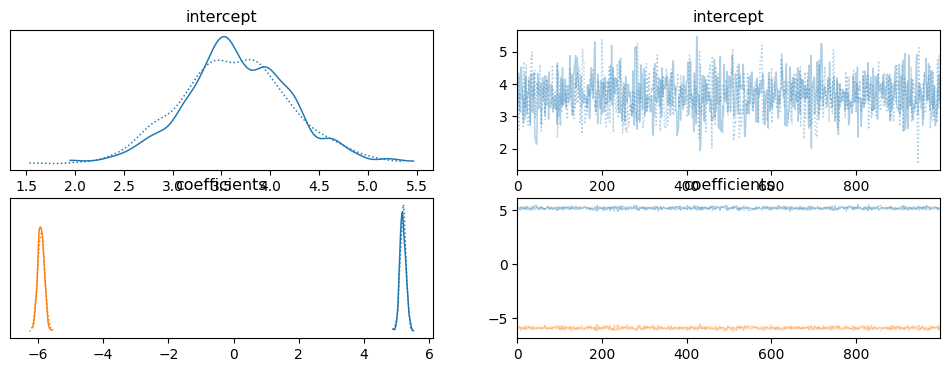

In [15]:
import arviz as az
az.plot_trace(sim_data)

In [18]:
import arviz as az; print("number of MCMC samples:", sim_data.posterior['intercept'].values.flatten().shape[-1])
az.summary(sim_data, round_to = 4)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.6529,0.5571,2.6742,4.7749,0.0177,0.0125,991.4244,872.7305,1.0010
coefficients[0],5.1915,0.0939,5.0197,5.3758,0.0033,0.0024,807.0494,909.0546,1.0017
coefficients[1],-5.8979,0.1041,-6.0988,-5.7101,0.0037,0.0026,810.4408,756.2052,1.0049




# Part II
## Case of Normal Prior: $\pmb \beta_i \sim Normal(0, s_i)$
We have
\begin{align*}
  \log p(\pmb \beta|\mb y) &\propto \log p(\beta) + \sum_{i=1}^{n}\log p(y_i|\mb \beta)\\
  &\propto -\f{1}{2}\sum_{i=1}^{n}\f{\beta_i^2}{s_i^2} - \f{1}{2}\sum_{i=1}^{n}(y_i - x_i^T\pmb \beta)^2\\
  &\propto -\f{1}{2}\left[\norm{y-X\pmb \beta}_2^2 + \norm{\pmb \gamma}_2^2\right]
\end{align*}
, where $\pmb \gamma = (\gamma_1,...,\gamma_p)$ and $\gamma_p = \f{\beta_i}{s_i}$
## Case of Laplace Prior: $\pmb \beta_i \sim Laplace(0,s_i)$
Recall that, in Laplace distribution, the scale parameter is positive. Thus, we have
\begin{align*}
  \log p(\pmb \beta|\mb y) &\propto \log p(\beta) + \sum_{i=1}^{n}\log p(y_i|\mb \beta)\\
  &\propto -\f{1}{2}\sum_{i=1}^{n}\left|\f{\beta_i}{s_i}\right| - \f{1}{2}\sum_{i=1}^{n}(y_i - x_i^T\pmb \beta)^2\\
  &\propto -\f{1}{2}\left[\norm{y-X\pmb \beta}_2^2 + \norm{\pmb \gamma}_1\right]
\end{align*}
, where $\pmb \gamma = (\gamma_1,...,\gamma_p)$ and $\gamma_p = \f{\beta_i}{s_i}$<br>
From the derivation above, we can see that, the posterior distribution is regularted by the prior through the term $\norm{\pmb \gamma}_{2}^{2}$ and $\norm{\pmb \gamma}_1$. In fact, if we assume $s_i = \f{1}{\lambda}$ for some $\lambda \in \R$ and all $i \in \{1,...,p\}$, then for the MAP inference/estimates with respect to the posterior, we recover the Rigde Regression for the Normal Prior and Lasso Regression for the Laplace Prior. However, as Baysian, we do not do MAP (which is MLE in some sense). Instead, we draw samples from the poesterior to conduct inference. That my understanding of the sentence posted in the question